# Tech Salary Analysis

### Research Questions:
- What are the average salaries for different experience levels?
- How do salaries vary by job title and location?
- What is the impact of remote work and copany size on salaries?
- Are there significant differences in salaries across regions?
- What trends can be observed over time (e.g., from 2023 to 2024)?

#### Import Packages

In [135]:
# This imports the necessary libraries for the project
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#### Loading Data

In [136]:
# This reads the data into a DataFrame
df = pl.read_csv("data/global_tech_salary.txt")
df.head()

work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
i64,str,str,str,i64,str,i64,str,i64,str,str
2023,"""MI""","""FT""","""Data Analyst""",165000,"""USD""",165000,"""AU""",0,"""AU""","""M"""
2023,"""MI""","""FT""","""Data Analyst""",70000,"""USD""",70000,"""US""",100,"""US""","""M"""
2024,"""MI""","""FT""","""Machine Learning Engineer""",85000,"""EUR""",94444,"""IE""",100,"""IE""","""M"""
2024,"""SE""","""FT""","""Data Scientist""",92700,"""USD""",92700,"""US""",0,"""US""","""M"""
2023,"""MI""","""FT""","""Research Engineer""",150000,"""USD""",150000,"""US""",0,"""US""","""M"""


#### Data Preparation

1. To reduce the amount of job title variation, only the 10 most frequent job titles will be reviewed.

In [137]:
freq_jobs = df.group_by(["job_title"]).len().sort(by="len", descending=True).head(10)

In [138]:
freq_jobs

job_title,len
str,u32
"""Data Engineer""",1067
"""Data Scientist""",1025
"""Data Analyst""",735
"""Machine Learning Engineer""",511
"""Research Scientist""",153
"""Analytics Engineer""",127
"""Applied Scientist""",125
"""Data Architect""",117
"""Business Intelligence Engineer""",92


In [139]:
df = df.join(freq_jobs, how="inner", on=["job_title"])

#### Exploratory Data Analysis

Salary Distibution

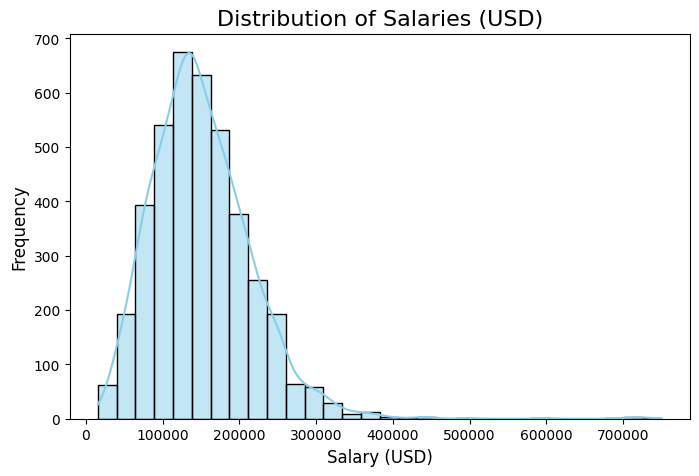

In [140]:
# This plots the distribution of salaries
plt.figure(figsize=(8, 5))
sns.histplot(df['salary_in_usd'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Salaries (USD)', fontsize=16)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

> This shows a right skewed graph where the distribution is very heavily focused around 120-150K as the salary amount.

Salaries by Experience Level

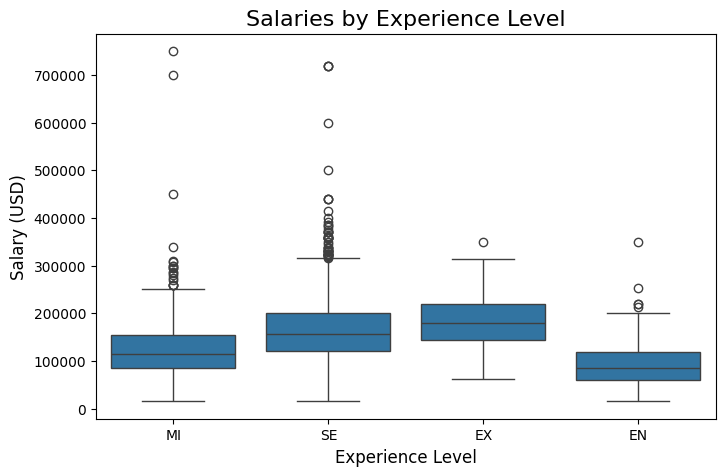

In [141]:
# Boxplot of salaries by experience level
plt.figure(figsize=(8, 5))
sns.boxplot(df, x='experience_level', y='salary_in_usd')
plt.title('Salaries by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.show()

> This boxplot shows exactly as expected with the entry level generally receiving the lowest salary amount, followed by the middle, and senior guys. The expert level is obviously at the top.

Salaries by Job Title (Top 5 only)

/var/folders/x7/qrnrw4rd6jlbxb3n07zps4vh0000gn/T/ipykernel_69358/1549036443.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='job_title', y='salary_in_usd', palette='Set2')


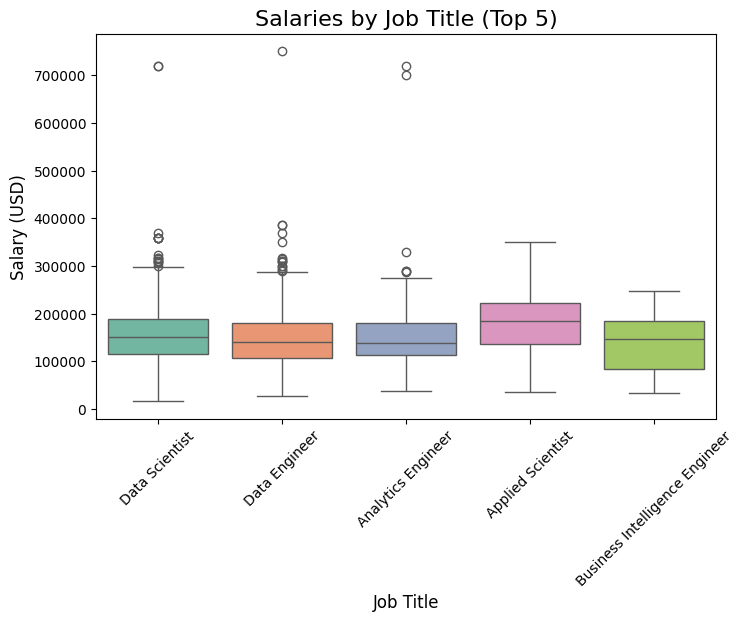

In [142]:
# Top 5 most frequent job titles
top_5_jobs = df['job_title'].value_counts().head(5)["job_title"].to_list()
filtered_data = df.filter(pl.col("job_title").is_in(top_5_jobs))

# Boxplot of salaries by job title (Top 5 only)
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_data, x='job_title', y='salary_in_usd', palette='Set2')
plt.xticks(rotation=45)
plt.title('Salaries by Job Title (Top 5)', fontsize=16)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.show()

> This shows that a lot of individuals in the data industry are making right around the same (150000) with applied Scientists and Machine Learning Engineers making a little more (closer to 200000)

Correlation Heatmap

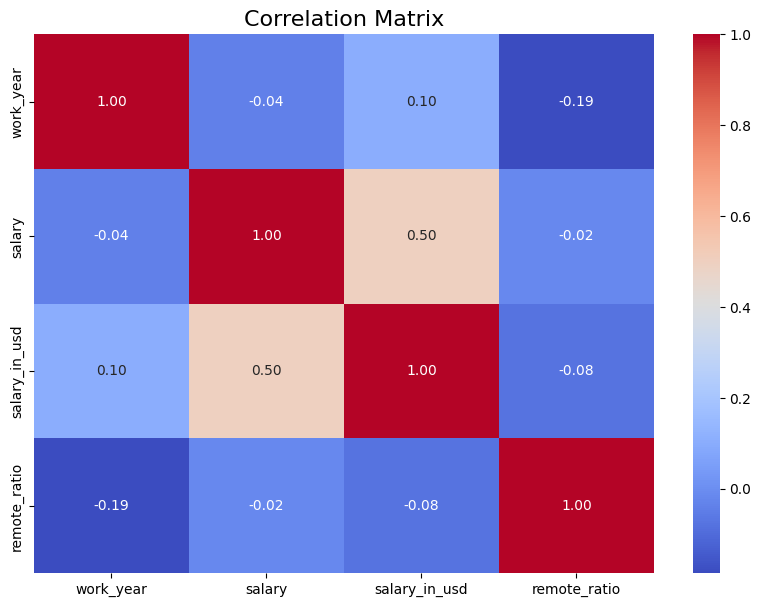

In [143]:
# Calculates correlation matrix
corr_matrix = df.select(pl.col(pl.Int64)).corr()

# Easier for labeling
corr_matrix = corr_matrix.to_pandas()

# Labeling for graphs
corr_matrix.columns = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
corr_matrix.index = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

# Plots heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.show()


> The heatmap displays the correlation coefficients between key variables in the dataset, showing how each feature relates to the others. For reference, the correlation between salary and salary in USD is moderate (0.50), indicating a positive relationship, while the remote ratio shows weak negative correlations with salary and salary in USD.

### Modeling

In [145]:
# Feature selection
X = df.drop(["salary_in_usd"])
y = df['salary_in_usd']

# One-hot encoding
X = X.to_dummies(drop_first=True)

# Splits the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Trains model
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

### Model Evaluation

In [146]:
# Predictions
y_pred = model.predict(X_test)

# Calculates MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 1783109254.9590843
R-squared: 0.5776022682704383


> The Mean Squared Error (MSE) of 1.78 billion and R-squared value of 0.578 indicate that the model captures a moderate portion of the variation in salaries. The MSE suggests that, on average, the model’s salary predictions deviate by a significant margin, though it has improved compared to previous iterations. The R-squared value of 57.8% shows that the model explains more than half of the variation in salaries based on the selected features (remote ratio, experience level, and company size). While this is a reasonable improvement, further refinements—such as incorporating additional relevant features, optimizing hyperparameters, or exploring alternative machine learning models—could enhance accuracy even further.

### Hyperparameter Tuning

In [147]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Initializes the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Performs GridSearching
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_

# Finds best model (Still not good)
y_pred_best = best_rf_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model MSE: {mse_best}")
print(f"Best Model R-squared: {r2_best}")


Best Parameters from GridSearchCV: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Model MSE: 1758427644.8945003
Best Model R-squared: 0.5834490530805777


> The best parameters from GridSearchCV were {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}, which optimized the decision tree depth, sample split, and number of estimators for better performance. With these parameters, the Best Model MSE is 1.76 billion, and the R-squared value of 0.583 indicates that the model explains 58.3% of the variation in salaries. This represents a significant improvement over previous iterations, though there is still room for enhancement by incorporating additional relevant features or experimenting with alternative modeling approaches.

### Cross-Validation

In [148]:
# K-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculates the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"Cross-validation Mean MSE: {-cv_mean}")
print(f"Cross-validation Std MSE: {cv_std}")

Cross-validation Mean MSE: 1894548314.1817493
Cross-validation Std MSE: 436221397.08193713


> The cross-validation mean MSE of approximately 1.89 billion is slightly worse than the best model, with a standard deviation of about 436.2 million, indicating some variability in model performance. This suggests that the model is unstable and still not accurate enough, requiring more refined features or different algorithms for improvement.

### Residual Analysis

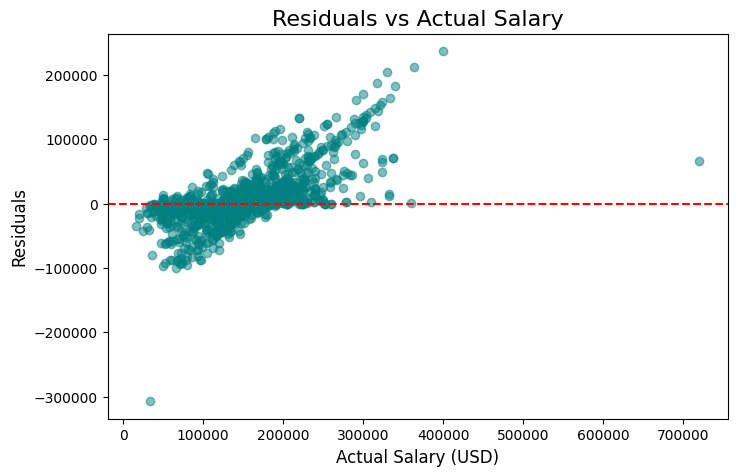

Mean Absolute Error (MAE): 25280.65962901896


In [149]:
# Residuals (errors) of the model
residuals = y_test - y_pred

# Plots the residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_test, residuals, alpha=0.5, color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual Salary', fontsize=16)
plt.xlabel('Actual Salary (USD)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()

# Displaying the Mean Absolute Error for better understanding
mae = (abs(residuals)).mean()
print(f"Mean Absolute Error (MAE): {mae}")


> The residuals plot shows a roughly 45-degree angle, indicating a systematic bias in the model’s predictions, with the errors not being randomly distributed around zero. The Mean Absolute Error (MAE) of 25,280 USD further highlights that the model’s predictions are off by about 25,000 USD on average, suggesting the need for improvements.